# Nerdle Solver - Initial Guess Assessment Optimization
We prove (by brute-force) that you can always solve mini-Nerdle in at most $4$ guesses regardless of the starting expression, provided you use the optimal strategy. The worst start having repeating numbers and thus less information, e.g. `10-5=5`. The best start has all different numbers: `28/7=4`, which needs at most $3$ guesses and $2.65 \pm 0.5$ guesses.

To find the best initial guess, we map out the game tree.

In [373]:
%load_ext autoreload
%autoreload 2

import collections
import ctypes
import itertools
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import pickle

import analysis
import nerdle
import score as s
import generator
sgo = ctypes.CDLL(s.SCORE_GUESS_OPT_SO)
from nerdle import Hint

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initial Guess Optimization

num_slots 5
Building tree
CPU times: user 149 ms, sys: 3.19 ms, total: 152 ms
Wall time: 154 ms
Best initial guess 1+2=3 #nodes 286 #leaves 217
2 guesses:   8.76%
3 guesses:  43.78%
4 guesses:  24.42%
5 guesses:  23.04%
num_slots 6
Building tree
CPU times: user 88 ms, sys: 1.01 ms, total: 89 ms
Wall time: 90.7 ms
Best initial guess 3*8=24 #nodes 250 #leaves 206
2 guesses:  15.05%
3 guesses:  83.98%
4 guesses:   0.97%
num_slots 7
Building tree
CPU times: user 2min 6s, sys: 941 ms, total: 2min 7s
Wall time: 2min 7s
Best initial guess 24-16=8 #nodes 9363 #leaves 7561
2 guesses:   1.44%
3 guesses:  57.23%
4 guesses:  41.33%
num_slots 8
Building tree


KeyboardInterrupt: 


KeyboardInterrupt



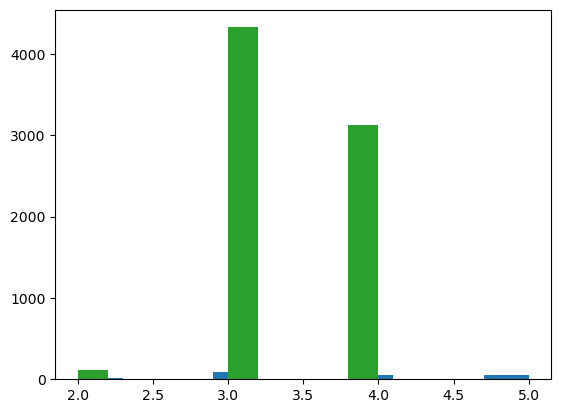

In [378]:
for num_slots in range(5, 9):
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db

    print("Building tree")
    %time tree = analysis.GameTreeBuilder(solver_data).build()
    tdc = TreeDepthCalculator(tree)
    tree_file = "db/nerdle{}_tree.pkl".format(num_slots) 
    with open(tree_file, 'wb') as f:
        pickle.dump(tree, f)

    # Distribution of #guesses for all answers.
    num_guesses = np.array([depth for node, depth in tdc.depth.items() if not node.children]) + 1
    freq = collections.Counter(num_guesses)
    num_leaves = sum(1 for node in tdc.depth if not node.children)

    print("Best initial guess", tree.key[1], "#nodes", len(tdc.depth), "#leaves", num_leaves)
    for k, v in sorted(freq.items()):
        print("{} guesses: {:6.2f}%".format(k, 100 * v / num_leaves))
    plt.hist(num_guesses);

In [377]:
for num_slots in range(5, 9):
    print("num_slots", num_slots)
    db_file = "db/nerdle{}.db".format(num_slots) 
    solver_data = nerdle.create_solver_data(num_slots, db_file)
    d = solver_data.score_db
    answers = solver_data.all_keys
    %time bucket_size, _, k = min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)
    b = collections.Counter(d[k]).values()
    print("{} bucket size {} reduction factor {:.1f} # buckets {}".format(
        solver_data.answers[k], bucket_size, d.shape[1] / bucket_size, len(b)))

num_slots 5
CPU times: user 10.6 ms, sys: 125 µs, total: 10.7 ms
Wall time: 10.9 ms
1+2=3 bucket size 42 reduction factor 5.2 # buckets 43
num_slots 6
CPU times: user 9.94 ms, sys: 106 µs, total: 10 ms
Wall time: 10.2 ms
3*8=24 bucket size 10 reduction factor 20.6 # buckets 73
num_slots 7
CPU times: user 7.29 s, sys: 14.6 ms, total: 7.31 s
Wall time: 7.32 s
24-16=8 bucket size 158 reduction factor 47.9 # buckets 543
num_slots 8
CPU times: user 40.6 s, sys: 85.1 ms, total: 40.7 s
Wall time: 40.8 s
58-46=12 bucket size 101 reduction factor 175.5 # buckets 1650


* It seems like odd-size Nerdle is harder than even-size! Larger average #guesses.
* Diversifying symbols of initial guess is a generally good criterion.

In [411]:
import cProfile
import pstats
from pstats import SortKey

num_slots = 7
print("num_slots", num_slots)
db_file = "db/nerdle{}.db".format(num_slots) 
solver_data = nerdle.create_solver_data(num_slots, db_file)
d = solver_data.score_db

cProfile.run('tree = analysis.GameTreeBuilder(solver_data).build()', 'stats')
p = pstats.Stats('stats')
p.sort_stats(SortKey.CUMULATIVE).print_stats(20)

num_slots 7
Tue Sep 20 07:35:20 2022    stats

         122722432 function calls (122713070 primitive calls) in 171.127 seconds

   Ordered by: cumulative time
   List reduced from 37 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  171.127  171.127 {built-in method builtins.exec}
        1    0.001    0.001  171.127  171.127 <string>:1(<module>)
        1    0.001    0.001  170.851  170.851 /Users/olivne/oren/nerdle-solver/analysis.py:39(build)
   9363/1    0.018    0.000  170.849  170.849 /Users/olivne/oren/nerdle-solver/analysis.py:90(pre_traversal)
     9363    0.046    0.000  170.832    0.018 /Users/olivne/oren/nerdle-solver/analysis.py:50(_process_node)
     1802    3.356    0.002  169.093    0.094 {built-in method builtins.min}
 13626724   94.301    0.000  165.738    0.000 /Users/olivne/oren/nerdle-solver/analysis.py:59(<genexpr>)
 13624922   12.999    0.000   65.684    0.000 /Users/olivne/opt/min

In [425]:
import scipy.stats

num_slots = 7
print("num_slots", num_slots)
db_file = "db/nerdle{}.db".format(num_slots) 
solver_data = nerdle.create_solver_data(num_slots, db_file)
d = solver_data.score_db
answers = solver_data.all_keys
%time bucket_size, _, k = min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)
b = collections.Counter(d[k]).values()
print("{} bucket size {} reduction factor {:.1f} # buckets {}".format(
    solver_data.answers[k], bucket_size, d.shape[1] / bucket_size, len(b)))

num_slots 7
CPU times: user 7.34 s, sys: 12 ms, total: 7.35 s
Wall time: 7.36 s
24-16=8 bucket size 158 reduction factor 47.9 # buckets 543


In [432]:
%time min((b, k not in answers, k) for k, b in enumerate(scipy.stats.mode(d, axis=1, keepdims=False)[1]))

CPU times: user 1.89 s, sys: 10.3 ms, total: 1.9 s
Wall time: 1.9 s


(158, False, 1563)

In [426]:
%time min((max(collections.Counter(d[k]).values()), k not in answers, k) for k in solver_data.all_keys)

CPU times: user 7.36 s, sys: 18.7 ms, total: 7.38 s
Wall time: 7.39 s


(158, False, 1563)